# COGS 108 - Final Project (Relationship between language of GoFundMe Fundraiser and amount of money raised)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Overview

In this project, we looked into GoFundMe fundraisers and tried to see if there were any variables that contributed to more money raised in their campaign. Our data was directly scraped off the gofund me page. We used tfidf for text analysis and vader for sentiment analysis. The video can be found here: https://github.com/COGS108/Group_Sp23_Rise_and_Grind/blob/master/COGS108Video.mp4 

# Names

- Seiji Minowada
- Trung Le
- Sean Furhman
- Nikita Cardozo

<a id='research_question'></a>
# Research Question

In GoFundMe fundraisers, are there certain keywords or langauge that on average contribute to a higher overall amount of money raised overall for the fundraiser? (We can also see the breakdown on number of donors and average donation)

<a id='background'></a>

## Background & Prior Work

References (include links):
1) [Study 1](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9520814)
    * Focused on GoFundMe fundraisers
    * Broke fundraisers down by categories, found that successful fundraisers were usually related to health
    * Additionally broke categories down between target goal of 0-$8000, $8000-$40,000, and $40,000+
    * Found that the aesthetic of the cover picture of a fundraiser leads to a higher success rate for rundraising.
    * * Used a model called NIMA to process photo quality and judge aesthetic


2) [Study 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8901185/)
    * Focused on a single fundraiser by Wuhan University alumni during COVID
    * Anonymous donations are usually smaller than non anonymous donations
    * Based in china where social norms/pressure play a bigger role
    * Used snowNLP package for sentiment analysis

# Hypothesis


We predict that fundraisers on GoFundMe that use emotional and impactful keywords relating to personal struggles, urgency, and transparency along with lengthy detailed descriptions explaining their cause will lead to more donations and number of donors.

# Dataset(s)


 There is not any readily available dataset online for us to use for the project. Hence, we decided to use a web scraping script to retrieve relevant data directly from GoFundMe.
 
  The script that we used can be found in the following Githup repository: `https://github.com/gvsa123/GoFundMe`. Due to the outdated nature of the repo, a few slight modifications were made to the scripts themselves to ensure that they would work as expected. The scripts that we used to gather our data from GoFundMe are: `scrape_by_campaign.py` (Used for scrapping campaigns within specific categories) and `go_fund_links_scrapper.py` (used for getting the links to different type of campaigns)
  
  Due to the intensive computing time required to run the script and limited resources, we were able to gather data for only 1245 GoFundMe campaigns.  The dataset can be found under `master.csv` as a csv format. 

  Our dataset are organized under the following format:

  |Column Header|Data Type|Description|
|:---|:---|:---|
|`title`|string|The given title for the campaign as published on the GoFundMe webpage|
|`raised`|int64|Total dollar (USD) amount  raised at time of scraping. The actual value in the dataset may change depending on whether the campaign had reached it’s target amount or not.|
|`target`|int64|The published target amount for the campaign.|
|`m_campaign`|string|One of 18 categories set by GoFundMe to categorize each individual campaign.|
|`created_date`|datetime64|The date the campaign was officially launched in the GoFundMe website|
|`donors`|float64|Total number of donors for the campaign|
|`shares`|float64|Total number of social media shares for the campaign using embedded media sharing feature of the GoFundMe website|
|`followers`|float64|Total number of followers for the campaign|
|`scrape_date`|datetime64|Date of data mining|



# Setup

In [110]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

dataset = pd.read_csv("master.csv")

# Data Cleaning

First, we will drop the following three columns since they are not important to the analysis that we will be performing. And they contain a bunch of NaNs anyways

In [111]:
dataset = dataset.drop(["Unnamed: 0", "shares", "followers"], axis=1)

Then, we will convert the target and raised to integers to make them more useable

In [112]:
dataset['target'] = dataset['target'].str.replace('[\$,]', '', regex=True).astype(int)
dataset['raised'] = dataset['raised'].str.replace('[\$,]', '', regex=True).astype(int)

Then we need to convert the story column into more usuable text data. This section gets rid of all punctuation, makes every word lowercase, and seperates all the words by a space. 

In [113]:
def clean_story(story):
    out = story.lower()
    out = re.sub(r'[^\w\s]', ' ', out)   
    out = out.replace('\n', ' ')
    out = out.split()
    out = " ".join(out)

    return out

dataset['story'] = dataset['story'].apply(clean_story)
dataset.head()

,url_index,title,raised,target,story,m_campaign,donors,scrape_date
0,fundraising-for-harsh-patels-rehab-treatment?q...,Harsh's Paralysis Treatment,34954,80000,i one of harsh s friends who was present durin...,medical-fundraising,80000,2023-05-17 20:28:30.018633
1,umang-our-jedis-go-fund-me-page?qid=c188f10a35...,"Umang, our Jedi's Cancer Fight",101242,100000,dearest friends and family we are reaching out...,medical-fundraising,100000,2023-05-17 20:28:30.018633
2,d8ykku-support-jason-and-his-family?qid=c188f1...,Support Jason and his family.,31185,25000,dear friends and wps family we are reaching ou...,medical-fundraising,25000,2023-05-17 20:28:30.018633
3,rootin-for-ryley?qid=c188f10a35a214c1c46a0ae2d...,Rootin' for Ryley,13805,10000,as some of you may or may not be aware one of ...,medical-fundraising,10000,2023-05-17 20:28:30.018633
4,7-month-nafisa-with-sma-type-1?qid=c188f10a35a...,7 Month daughter with SMA type 1,104588,2700000,hello my name is mufaddal adamji and i am post...,medical-fundraising,2700000,2023-05-17 20:28:30.018633


Now that our text is cleaned up and the 'raised' and 'target' column transformed into integers, we are ready to do our data analysis and results. 

# Data Analysis & Results

First lets look at an overview of our data to get a general sense of what we are dealing with

In [114]:
dataset.describe()

,raised,target,donors
count,1243.000000,1.243000e+03,1.243000e+03
mean,10689.509252,3.226811e+04,3.226811e+04
std,21782.400871,1.846606e+05,1.846606e+05
min,5.000000,1.000000e+00,1.000000e+00
25%,1040.000000,4.500000e+03,4.500000e+03
50%,3690.000000,1.000000e+04,1.000000e+04
75%,11334.000000,2.500000e+04,2.500000e+04
max,367489.000000,5.000000e+06,5.000000e+06


Next, we are just gonna do a preliminary check if description length corresponds to raised money

Correlation between length and raised:  0.059284212951151834


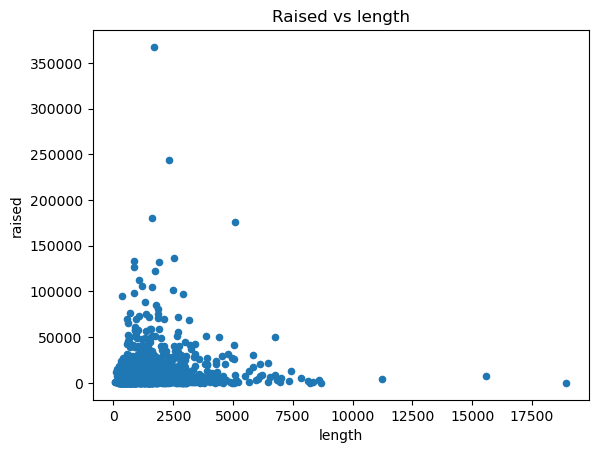

In [115]:
dataset['length'] = dataset['story'].apply(len)

length_correlation = dataset['length'].corr(dataset['raised'])
print("Correlation between length and raised: ", length_correlation)

plot_df = pd.DataFrame({'raised': dataset['raised'], 'length': dataset['length']})
plot_df.plot.scatter(x='length', y='raised')
plt.title(f"Raised vs length")
plt.show()

This graph has some clear outliers, so lets try limiting our inputs. Lets see if removing these potential outliers reveals any relationships between length and money raised. 

Correlation between length and raised:  0.06702780703124626


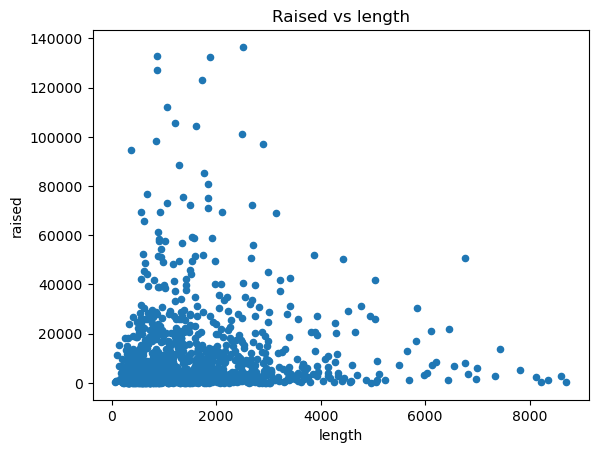

In [116]:
remove_outliers = dataset[['length','raised']]
remove_outliers.head()
remove_outliers = remove_outliers[remove_outliers['raised'] <= 150000]
remove_outliers = remove_outliers[remove_outliers['length'] <= 10000]


length_correlation = remove_outliers['length'].corr(remove_outliers['raised'])
print("Correlation between length and raised: ", length_correlation)

plot_df = pd.DataFrame({'raised': remove_outliers['raised'], 'length': remove_outliers['length']})
plot_df.plot.scatter(x='length', y='raised')
plt.title(f"Raised vs length")
plt.show()

As we can see by the graph and the correlation coefficient, there is still not a clear relationship since our correlation coefficient is still less than .1. 

To answer our hypothesis, we are gonna further investigate word distribution and take the tf-idf of all the GoFundMe Stories. We take the tf-idf instead of term frequency because it finds impactactful words instead of finding the most common words. 

In [117]:
nltk.download('punkt')
nltk.download('stopwords')
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500, tokenizer=word_tokenize, stop_words=stopwords.words("english"))

stories_list = dataset['story'].tolist()
matrix = tfidf.fit_transform(stories_list)
stories_tfidf = pd.DataFrame(matrix.toarray(), columns=tfidf.get_feature_names_out())
stories_tfidf

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seijiminowada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seijiminowada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/seijiminowada/anaconda3/envs/SeanIsBetterThanMe/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/seijiminowada/anaconda3/envs/SeanIsBetterThanMe/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


,000,1,10,100,12,2,20,2022,2023,3,...,world,would,www,year,years,young,youth,à,été,être
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098244,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.060876,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079288,...,0.000000,0.100588,0.000000,0.000000,0.064433,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.129518,0.000000,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,0.106465,0.000000,0.000000,0.000000,0.000000,0.000000,0.076865,0.000000,...,0.000000,0.067703,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.114155,0.119301,0.000000,0.144465,0.000000,0.104327,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,0.000000,0.000000,0.000000,0.158798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.156992,0.126244,0.0,0.000000,0.0,0.0
1239,0.044441,0.097469,0.000000,0.000000,0.000000,0.040615,0.000000,0.000000,0.000000,0.040410,...,0.119592,0.114228,0.092667,0.034973,0.000000,0.000000,0.0,0.000000,0.0,0.0
1240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.266082,0.0,0.0
1241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163668,0.000000,0.000000,...,0.138719,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


Then we find which word's tf-idf is highly correlated with how much was raised

In [118]:
correlations = {}
for word in tfidf.get_feature_names_out():
    correlations[word] = dataset['raised'].corr(stories_tfidf[word])

correlations = sorted(correlations.items(), key=lambda x:x[1], reverse=True)
correlations[0:10]

[('family', 0.2710025672600949),
 ('wife', 0.23057173181443066),
 ('treatment', 0.18997451662682543),
 ('hearts', 0.18411379911605083),
 ('kindness', 0.173647938415267),
 ('age', 0.1634438794855864),
 ('news', 0.16263468045298246),
 ('suffered', 0.16092201229768455),
 ('friends', 0.15772787040765932),
 ('difficult', 0.15467080041968995)]

Here we have the top 10 correlated words. As can be seen, the words 'family', 'wife', 'treatment', 'hearts',  and 'kindness' are the highest correlated with money raised. We can investigate this further by analyzing these words individually

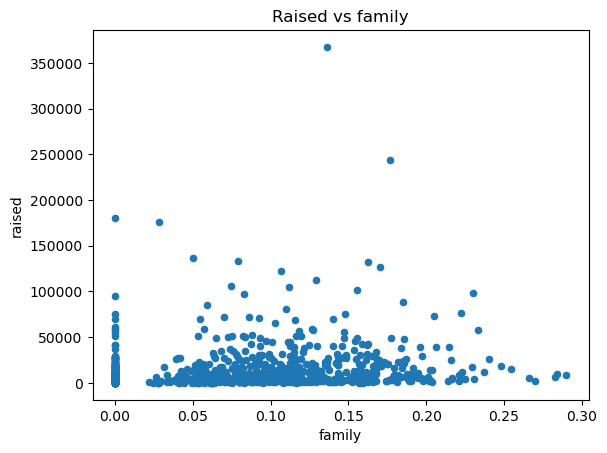

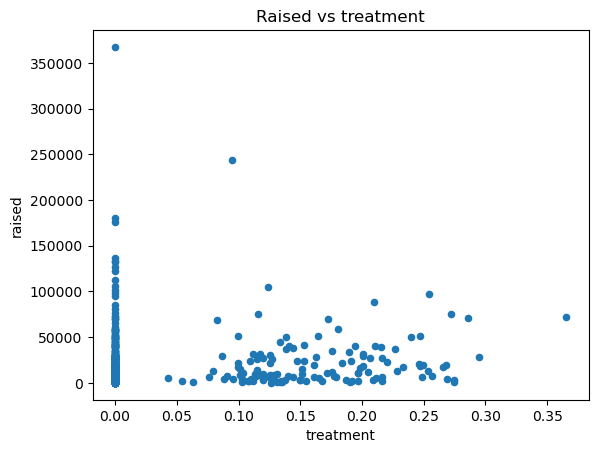

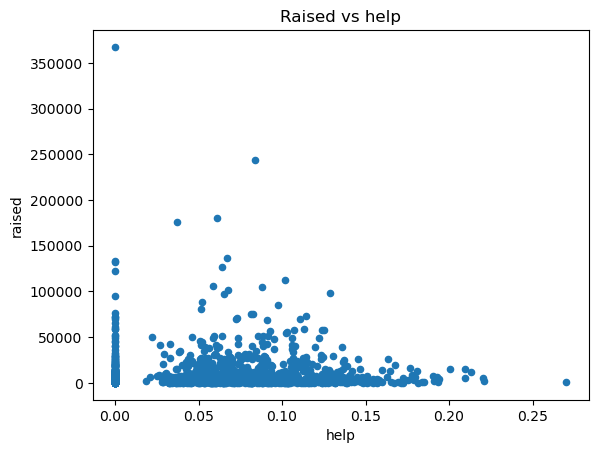

In [119]:
def plot_word(word):
    plot_df = pd.DataFrame({'raised': dataset['raised'], word: stories_tfidf[word]})
    plot_df.plot.scatter(x=word, y='raised')
    plt.title(f"Raised vs {word}")
    plt.show()

plot_word('family')
plot_word('treatment')
plot_word('help')

Now, lets try to see if our data changes when looking at the ratio of raised to target. This can help remove some noise in our data as some fundraisers are on a much larger scale. I have also capped the max amount raised vs target as 3 times as much as raised in hopes to limit our outliers. This can help prevent against people who set very low goals such as $5 and raised a large amount of money

In [120]:
dataset['ratio'] = dataset['raised']/dataset['target']
dataset.head()
temp = dataset[dataset['ratio'] < 3]
temp.head()

,url_index,title,raised,target,story,m_campaign,donors,scrape_date,length,ratio
0,fundraising-for-harsh-patels-rehab-treatment?q...,Harsh's Paralysis Treatment,34954,80000,i one of harsh s friends who was present durin...,medical-fundraising,80000,2023-05-17 20:28:30.018633,2554,0.436925
1,umang-our-jedis-go-fund-me-page?qid=c188f10a35...,"Umang, our Jedi's Cancer Fight",101242,100000,dearest friends and family we are reaching out...,medical-fundraising,100000,2023-05-17 20:28:30.018633,2487,1.012420
2,d8ykku-support-jason-and-his-family?qid=c188f1...,Support Jason and his family.,31185,25000,dear friends and wps family we are reaching ou...,medical-fundraising,25000,2023-05-17 20:28:30.018633,1637,1.247400
3,rootin-for-ryley?qid=c188f10a35a214c1c46a0ae2d...,Rootin' for Ryley,13805,10000,as some of you may or may not be aware one of ...,medical-fundraising,10000,2023-05-17 20:28:30.018633,1949,1.380500
4,7-month-nafisa-with-sma-type-1?qid=c188f10a35a...,7 Month daughter with SMA type 1,104588,2700000,hello my name is mufaddal adamji and i am post...,medical-fundraising,2700000,2023-05-17 20:28:30.018633,1623,0.038736


Here we have added an additional column to our dataset with the ratio of raised to target. A small number means they have barely raised any of their goal, a number close to 1 means they are near their goal, and any number over 1 means they have exceeded their goal. Lets run our analysis again with our ratio. 

In [121]:
correlations = {}
for word in tfidf.get_feature_names_out():
    correlations[word] = temp['ratio'].corr(stories_tfidf[word])

correlations = sorted(correlations.items(), key=lambda x:x[1], reverse=True)
correlations = dict(correlations)


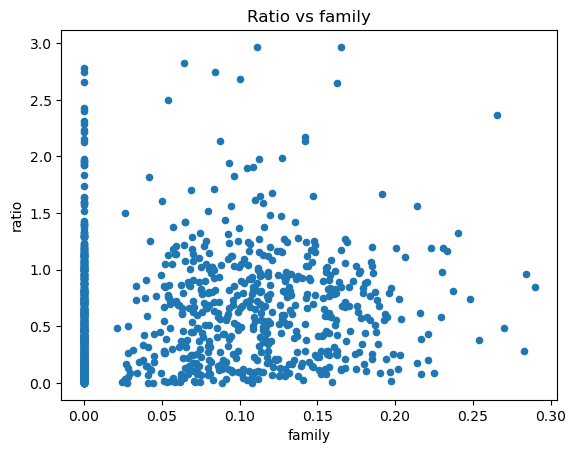

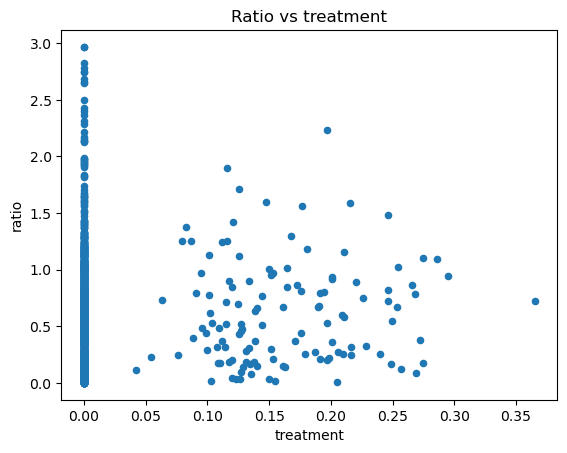

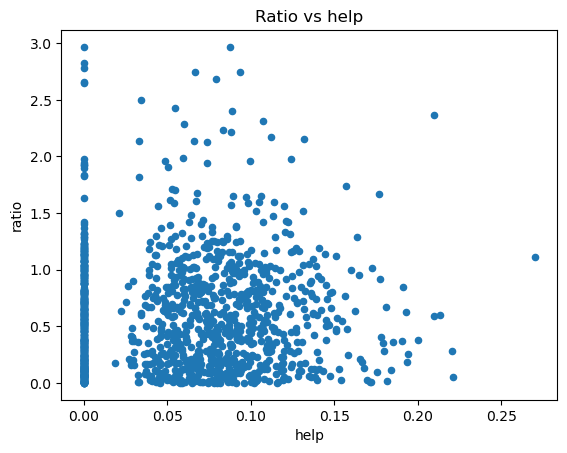

In [122]:
def plot_word(word):
    plot_df = pd.DataFrame({'ratio': temp['ratio'], word: stories_tfidf[word]})
    plot_df.plot.scatter(x=word, y='ratio')
    plt.title(f"Ratio vs {word}")
    plt.show()

plot_word('family')
plot_word('treatment')
plot_word('help')

Again, even with looking at the ratio of raised to target we can see that there are still not large correlations between keywords and amount raised. 

Now lets see if sentiment can have an affect on the amount raised. Perhaps those with emotional messages raise more money. A sentiment close to -1 means it has a very negative description. A sentiment close to 1 means it has a very positive description

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/seijiminowada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Correlation between sentiment score and raised:  0.020445631087573548


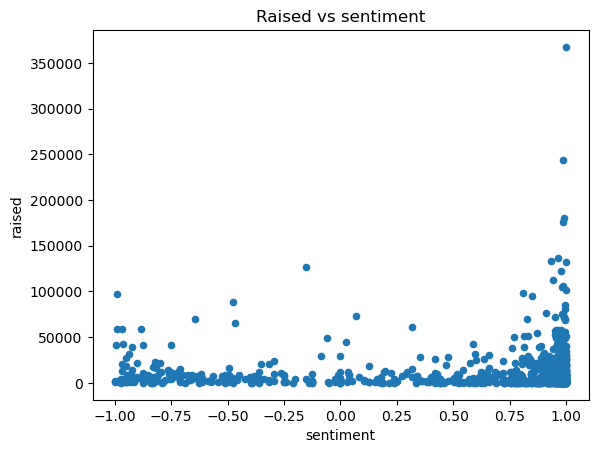

In [123]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment_score = sid.polarity_scores(text)
    return sentiment_score['compound']

dataset['sentiment_score'] = dataset['story'].apply(get_sentiment_score)

sentiment_correlation = dataset['sentiment_score'].corr(dataset['raised'])
print("Correlation between sentiment score and raised: ", sentiment_correlation)


plot_df = pd.DataFrame({'raised': dataset['raised'], 'sentiment': dataset['sentiment_score']})
plot_df.plot.scatter(x='sentiment', y='raised')
plt.title(f"Raised vs sentiment")
plt.show()

We can see a clustering twoards the extremes with more clustering towards the positive side. Our correlation coefficient is again very close to zero indicating a weak correlation. Lets try capping our raised value at $150000 and see if the graph shows a little better. 

Correlation between sentiment score and raised:  0.0012626112907628503


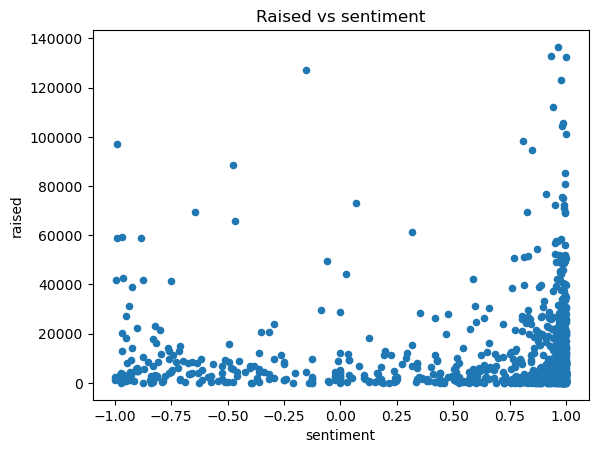

In [124]:
temp = dataset[dataset['raised'] <= 150000]
sentiment_correlation = dataset['sentiment_score'].corr(temp['raised'])
print("Correlation between sentiment score and raised: ", sentiment_correlation)


plot_df = pd.DataFrame({'raised': temp['raised'], 'sentiment': dataset['sentiment_score']})
plot_df.plot.scatter(x='sentiment', y='raised')
plt.title(f"Raised vs sentiment")
plt.show()

Again, we have a weak correlation but the data points are a little more spread out so we have a better sense of the distribution. As we saw before there are clusterings at each end of the sentiment. 

# Ethics & Privacy

Possible ethical concerns could be that gofundme creators might not want their websites with the information to be used in our research. A lot of the fundraisers are trying to raise money for people that are sick or in difficult conditions. 
- <b>Informed consent: did they agree to have their data used in our project?</b>
- No, they didn’t agree to have their information being used in our study but they are aware the fundraisers are public and anyone can see them. 
- <b>Limit personally identifiable information: have we found a way to limit information of people that could be released?</b> 
- We don’t need to include people’s names in the information to show in our report and can replace them with Jane/John Doe.
- <b>Schedule or plan to delete data after we get it?</b>
- No, this project will be public for anyone to see. 
- <b>Data with PII not shown: there could be people’s names and private info on the GoFundMe title and description</b> 
- We can choose not to use their names in our project


# Conclusion & Discussion

After our research, we saw that there are many factors at play when it comes to a gofundme. Our initial hypothesis was proven incorrect when based solely on keywords. There were weak correlations between keywords and amount raised as well as ratio of amount raised. \
Next, we looked at sentiment. Again, our calculations showed a weak correlation. By looking at the graph, this can be contributed to the clustering on both sides of the extremes near -1 and 1. This makes sense as many gofundmes are to help those in need after a disaster or to help something positive like a wedding. \
If we had a more complete dataset it would be easier to draw more conclusions. However there is not a collection of finished gofundmes with duration. To the best of our knowledge the fundraisers remain up until they are taken down.\
To conclude, it does not seem like there is one variable that strongly correlates to raising a large sum of money. We believe that it is the combination of variables as well as other factors that are not represented on the fundraiser such as how people are getting the word out about them. Is it just word of mouth or is the fundraiser circulating on social media and the news? 

# Team Contributions

<b> Nikita</b>

- Worked on project proposal and Ethics & Privacy section. Also wrote our research question and hypothesis. Helped with team expecations and creating the timeline proposal. Created video explaining final project. 

<b> Trung </b>

- Found a script off github for gofund me scraping. Edited the script as it was not fully functioning. Gathered our data and put it together in the dataset. Also cleaned up all the data so that we could use it for our analysis

<b> Sean </b>

- Focused on the data analysis and EDA. Used tfidf to see if there were any correlations between keywords and amount raised. Also used VADER for sentiment analysis to see if that had any affect on amount raised. 

<b> Seiji </b>

- Worked on the background section and researched similar projects to see what they did.  Helped with the  data analysis section when doing analysis regarding ratios. 